---
**Report for EMAT30008**

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

***Software Demo***

In [1]:
# Import our library and other packages needed for the demo
import numpy as np
import matplotlib.pyplot as plt
from scicomp.odefunctions import *

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



*1)*   We consider the Brusselator system:

$\frac{dx}{dt} = A + x^2 y - (B + 1)x$

$\frac{dy}{dt} = B x - x^2 y$

which undergoes a supercritical Hopf bifurcation for $B=1+A^2$. We fix $A=1$ (so our bifurcation occurs at $B=2$).

*(a)* We fix $B=3$ and calculate the solution for $0\leq t \leq 20$, starting from initial state $(1,1)$. We use the Euler timestepping method with a step size of $0.01$, and we plot both variables over time on a single figure.

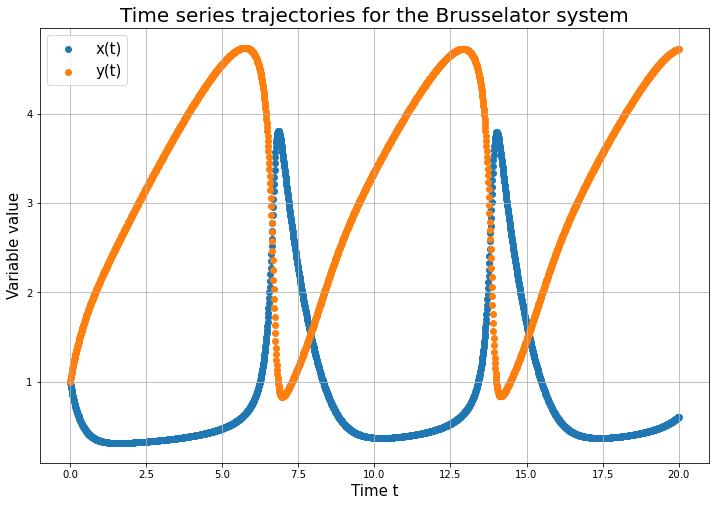

In [11]:
# First define the system ODE as a function
def brusselator(params: list[float], x:np.ndarray, t:float):
    ''' RHS of the Brusselator ODE.'''

    # Unpack parameters and variables
    A,B = params
    x,y = x[0], x[1]

    # Calculate each expression
    dxdt = A + (x**2)*y - (B+1)*x
    dydt = B*x - (x**2)*y
    return np.array(([dxdt, dydt]))

# Call the solve_to function, using the Euler method with a step size of 0.01
params = [1,3]
x_init = np.array(([1,1]))
t_init, t_final = 0, 20
deltat_max = 0.01
method = 'Euler'
store = solve_to(brusselator, params, x_init, t_init, t_final, deltat_max, method)

# Plot the x and y solutions versus time
tvals = store[:,0]
xvals, yvals = store[:,1], store[:,2]
plt.figure(figsize=[12,8])
plt.scatter(tvals,xvals, label='x(t)')
plt.scatter(tvals, yvals, label='y(t)')
plt.grid()
plt.legend(fontsize=15)
plt.xlabel("Time t", fontsize=15)
plt.ylabel("Variable value", fontsize=15)
plt.title("Time series trajectories for the Brusselator system", fontsize=20)
plt.show()


*(b)* We use numerical shooting to identify the coordinates of a starting point along the limit cycle seen above, along with its period. We use a constant phase condition. From the plot above we use $7.5$ as an estimate for the period, $(1.5,1.5)$ as an intial condition, and $1.5$ for the constant value.

In [3]:
init_period_guess = 7.5
init_point_guess = [1.5,1.5]
constant_value = 1.5
# Call the find_limit_cycle function with these guesses
period, init_point = find_limit_cycle(brusselator,params, init_point_guess, init_period_guess,
                                      1,'constant', constant_value)

A limit cycle was found:
Period: 7.16 ,
Starting state: [1.5  1.56] .


*(c)* We use natural-parameter continuation to find the branch of limit cycles emerging from the Hopf bifurcation at $B=2$

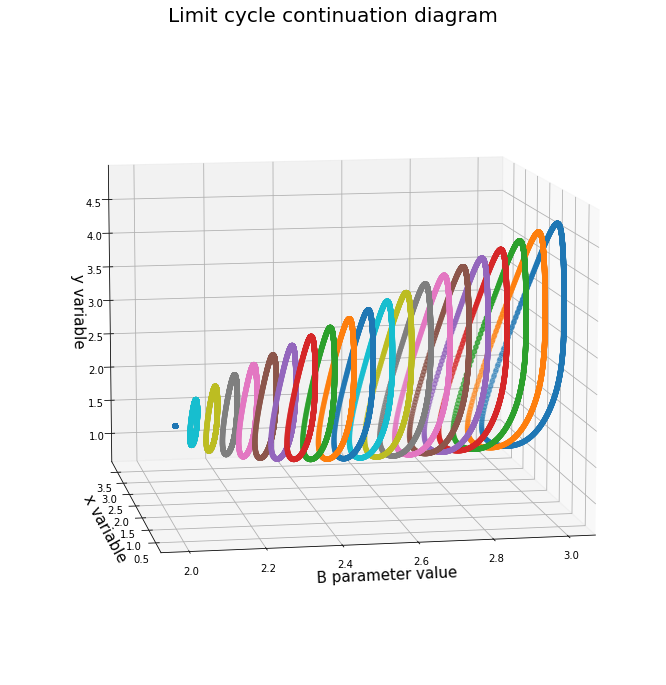

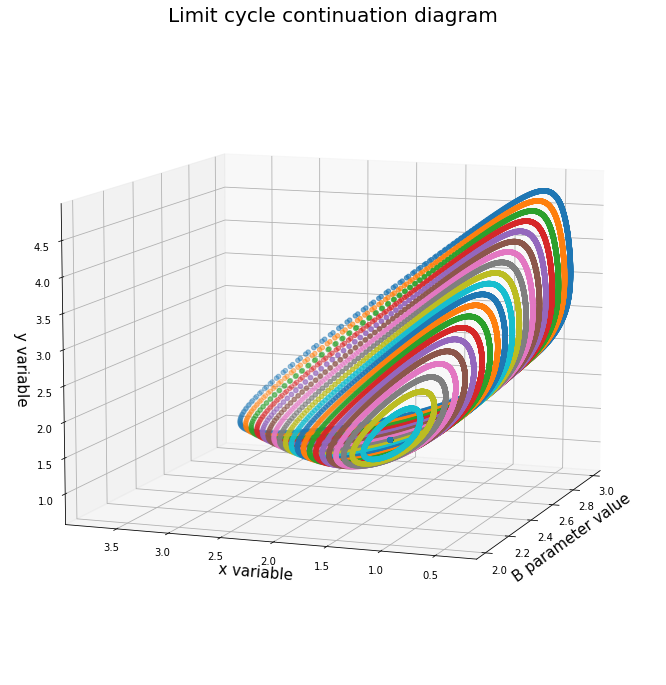

In [28]:
vary_param_index = 1
vary_param_start = 3
vary_param_step = -0.05
init_period_guess = 7.16
init_point_guess = np.array(([1.5,1.56]))
num_steps = 20
method = 'NPC'
phase_condition = 'constant'
constant_value = 1

# Call the limit_cycle_continuation function to vary B in steps of 0.01 from 2 to 3.
# We use natural-parameter continuation with 100 steps, and for each limit cycle
# we search with a derivative phase condition
pair_store, B_store = limit_cycle_continuation(brusselator, params,
                                                vary_param_index, vary_param_start,
                                                vary_param_step,init_point_guess,
                                                init_period_guess, num_steps,
                                                method, 1, phase_condition, constant_value)

# We plot our findings on a 3D plot 
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')
for index, B in enumerate(B_store):
    params[vary_param_index]=B
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(brusselator,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,2]
    xvals = B*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,260)
plt.title("Limit cycle continuation diagram",pad=-20 ,fontsize=20)
ax.set_xlabel("B parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()
# We plot our findings on a 3D plot 
fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection='3d')
for index, B in enumerate(B_store):
    params[vary_param_index]=B
    period, init_point, = pair_store[index,0], pair_store[index,1:]
    store = solve_to(brusselator,params,init_point,0,2*period,0.01)
    yvals, zvals = store[:,1], store[:,2]
    xvals = B*np.ones([len(yvals)])
    ax.scatter(xvals,yvals,zvals, zorder=10*index)
ax.view_init(10,200)
plt.title("Limit cycle continuation diagram",pad=-20 ,fontsize=20)
ax.set_xlabel("B parameter value",fontsize=15)
ax.set_ylabel("x variable",fontsize=15)
ax.set_zlabel("y variable",fontsize=15)
plt.show()